In [1]:

import os
import findspark

os.environ["JAVA_HOME"] = r"C:\Program Files\Java\jdk-11"
os.environ["HADOOP_HOME"] = r"C:\hadoop"
os.environ["PATH"] = os.path.join(os.environ["JAVA_HOME"], "bin") + ";" + \
                     os.path.join(os.environ["HADOOP_HOME"], "bin") + ";" + \
                     os.environ["PATH"]

findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Analysis").getOrCreate()

print("Spark version:", spark.version)

Spark version: 3.5.7


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnan, isnull
import pandas as pd

# Initialize Spark
spark = SparkSession.builder.appName("BusDelayPrediction").getOrCreate()

# Load data
df = spark.read.csv("C:/Users/prayu/BusProject/final_project_dataset.csv", header=True, inferSchema=True)

# Display basic info
print("Dataset shape:", df.count(), "rows,", len(df.columns), "columns")
print("\nFirst 5 rows:")
df.show(5)

print("\nData types:")
df.printSchema()

# Check for missing values
print("\nMissing values:")
for col_name in df.columns:
    missing_count = df.filter(isnull(col(col_name))).count()
    print(f"{col_name}: {missing_count}")

# Remove duplicates
df_clean = df.dropDuplicates()
print(f"\nRows after removing duplicates: {df_clean.count()}")

# Check for null values in target variable
df_clean = df_clean.filter(col("Actual_Delay_Minutes").isNotNull())
print(f"Rows after removing null delays: {df_clean.count()}")

df_clean.show(10)

Dataset shape: 3960 rows, 6 columns

First 5 rows:
+----------+-----------+----+-----------+-------+--------------------+
|      Date|Day_of_Week|Line|Hour_of_Day|Weather|Actual_Delay_Minutes|
+----------+-----------+----+-----------+-------+--------------------+
|2025-11-01|   Saturday|   9|          7|  Sunny|                  15|
|2025-11-01|   Saturday|   9|          7|  Sunny|                  10|
|2025-11-01|   Saturday|   9|          8|  Sunny|                   8|
|2025-11-01|   Saturday|   9|          9|  Sunny|                  18|
|2025-11-01|   Saturday|   9|          9|  Sunny|                  10|
+----------+-----------+----+-----------+-------+--------------------+
only showing top 5 rows


Data types:
root
 |-- Date: date (nullable = true)
 |-- Day_of_Week: string (nullable = true)
 |-- Line: string (nullable = true)
 |-- Hour_of_Day: integer (nullable = true)
 |-- Weather: string (nullable = true)
 |-- Actual_Delay_Minutes: integer (nullable = true)


Missing values:


In [3]:
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

# Encode categorical variables
print("=== ENCODING CATEGORICAL VARIABLES ===\n")

# Day_of_Week encoding
day_indexer = StringIndexer(inputCol="Day_of_Week", outputCol="Day_Index")
df_clean = day_indexer.fit(df_clean).transform(df_clean)

# Weather encoding
weather_indexer = StringIndexer(inputCol="Weather", outputCol="Weather_Index")
df_clean = weather_indexer.fit(df_clean).transform(df_clean)

# Line encoding
line_indexer = StringIndexer(inputCol="Line", outputCol="Line_Index")
df_clean = line_indexer.fit(df_clean).transform(df_clean)

print("Encoded columns created:")
df_clean.select("Day_of_Week", "Day_Index", "Weather", "Weather_Index", "Line", "Line_Index").show(5)

# Feature scaling preparation
print("\n=== STATISTICS OF NUMERIC FEATURES ===\n")
df_clean.describe("Hour_of_Day", "Actual_Delay_Minutes").show()

# Create feature vector
print("\n=== CREATING FEATURE VECTOR ===\n")
feature_columns = ["Hour_of_Day", "Day_Index", "Weather_Index", "Line_Index"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_preprocessed = assembler.transform(df_clean)

print(f"Total features: {len(feature_columns)}")
print("\nFeature vector sample:")
df_preprocessed.select("features", "Actual_Delay_Minutes").show(5)

# Rename target column for ML
df_preprocessed = df_preprocessed.withColumnRenamed("Actual_Delay_Minutes", "label")

print(f"\nPreprocessed dataset size: {df_preprocessed.count()} rows")
print("\nFinal columns:")
df_preprocessed.printSchema()

=== ENCODING CATEGORICAL VARIABLES ===

Encoded columns created:
+-----------+---------+-------+-------------+----+----------+
|Day_of_Week|Day_Index|Weather|Weather_Index|Line|Line_Index|
+-----------+---------+-------+-------------+----+----------+
|   Saturday|      4.0|  Sunny|          0.0|   9|       0.0|
|   Saturday|      4.0|    Fog|          2.0|   9|       0.0|
|     Monday|      0.0|  Sunny|          0.0|   9|       0.0|
|     Monday|      0.0|  Sunny|          0.0|  9H|       1.0|
|    Tuesday|      2.0|  Sunny|          0.0|   9|       0.0|
+-----------+---------+-------+-------------+----+----------+
only showing top 5 rows


=== STATISTICS OF NUMERIC FEATURES ===

+-------+------------------+--------------------+
|summary|       Hour_of_Day|Actual_Delay_Minutes|
+-------+------------------+--------------------+
|  count|              3295|                3295|
|   mean|12.729590288315629|    9.30804248861912|
| stddev|3.4294018264614867|   6.671681558123775|
|    min|  

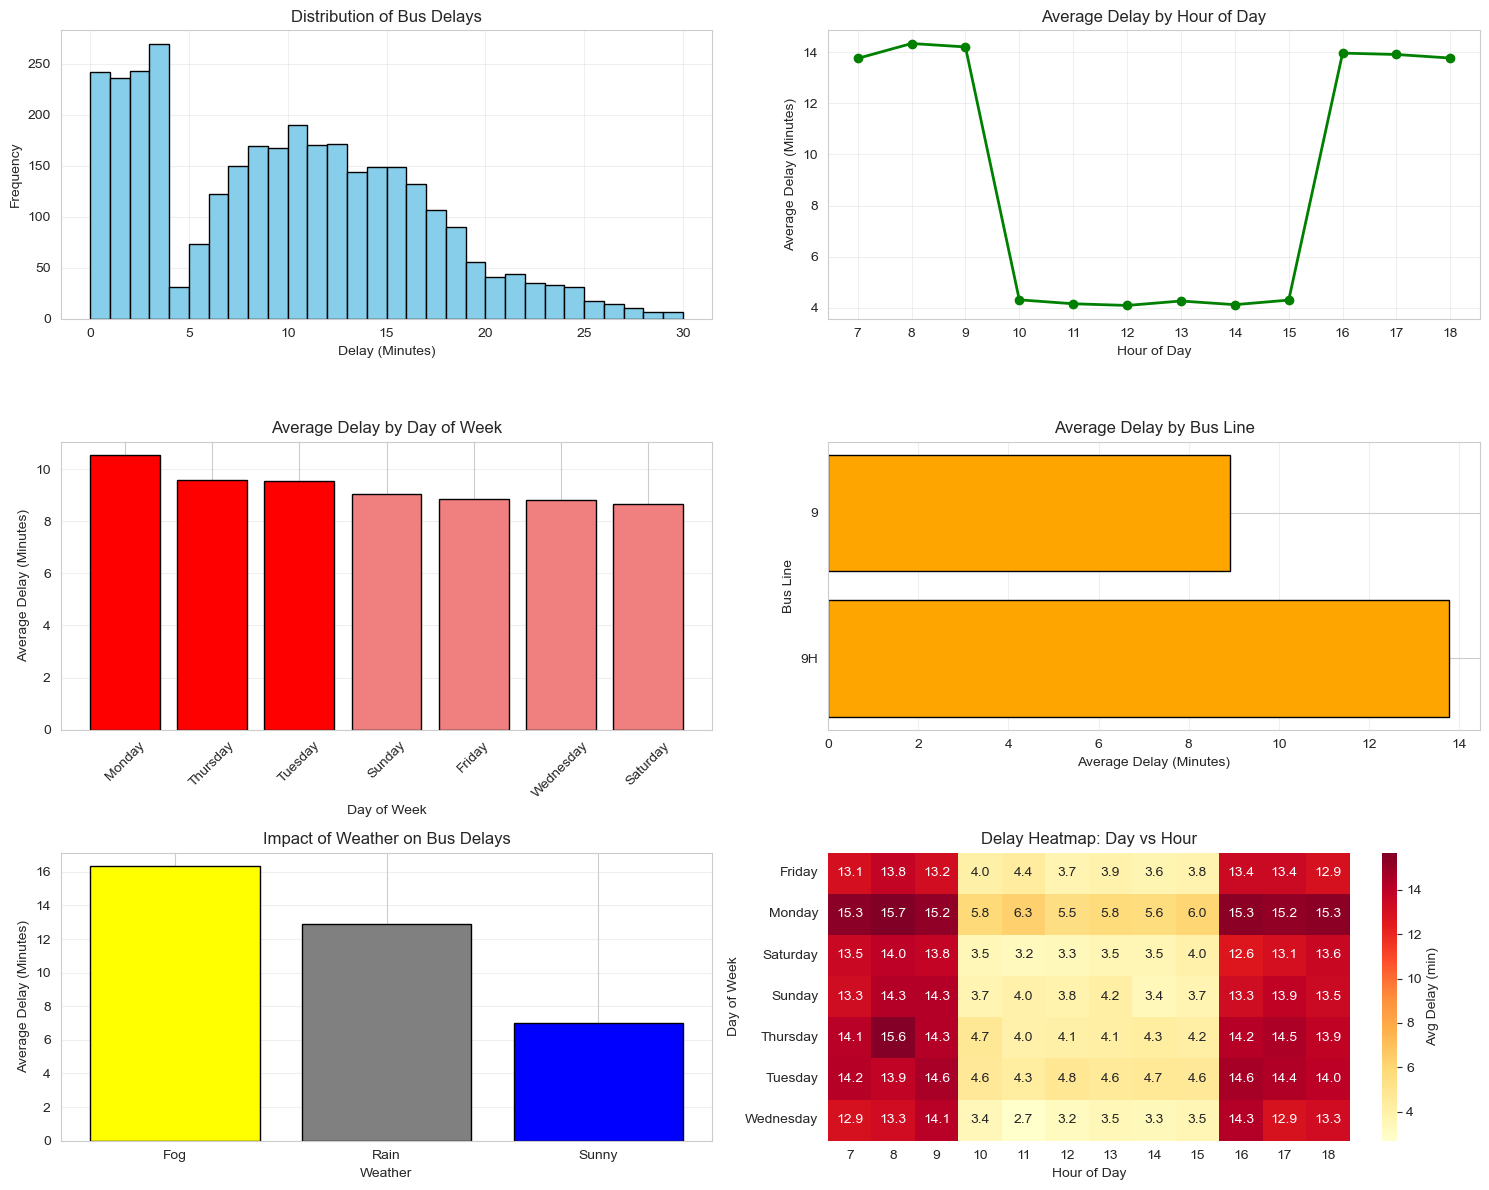

Visualizations saved to: C:/Users/prayu/BusProject/delay_visualizations.png


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert Spark DF to Pandas for visualization
df_viz = df_clean.toPandas()

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 12)

# ============ VISUALIZATION 1: Delay Distribution ============
plt.subplot(3, 2, 1)
plt.hist(df_viz['Actual_Delay_Minutes'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Delay (Minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Bus Delays')
plt.grid(True, alpha=0.3)

# ============ VISUALIZATION 2: Average Delay by Hour ============
plt.subplot(3, 2, 2)
delay_by_hour = df_viz.groupby('Hour_of_Day')['Actual_Delay_Minutes'].mean()
plt.plot(delay_by_hour.index, delay_by_hour.values, marker='o', color='green', linewidth=2)
plt.xlabel('Hour of Day')
plt.ylabel('Average Delay (Minutes)')
plt.title('Average Delay by Hour of Day')
plt.xticks(range(7, 19))
plt.grid(True, alpha=0.3)

# ============ VISUALIZATION 3: Delay by Day of Week ============
plt.subplot(3, 2, 3)
delay_by_day = df_viz.groupby('Day_of_Week')['Actual_Delay_Minutes'].mean().sort_values(ascending=False)
colors = ['red' if x > delay_by_day.mean() else 'lightcoral' for x in delay_by_day.values]
plt.bar(delay_by_day.index, delay_by_day.values, color=colors, edgecolor='black')
plt.xlabel('Day of Week')
plt.ylabel('Average Delay (Minutes)')
plt.title('Average Delay by Day of Week')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')

# ============ VISUALIZATION 4: Delay by Bus Line ============
plt.subplot(3, 2, 4)
delay_by_line = df_viz.groupby('Line')['Actual_Delay_Minutes'].mean().sort_values(ascending=False)
plt.barh(delay_by_line.index, delay_by_line.values, color='orange', edgecolor='black')
plt.xlabel('Average Delay (Minutes)')
plt.ylabel('Bus Line')
plt.title('Average Delay by Bus Line')
plt.grid(True, alpha=0.3, axis='x')

# ============ VISUALIZATION 5: Weather Impact on Delay ============
plt.subplot(3, 2, 5)
delay_by_weather = df_viz.groupby('Weather')['Actual_Delay_Minutes'].mean()
plt.bar(delay_by_weather.index, delay_by_weather.values, color=['yellow', 'gray', 'blue'], edgecolor='black')
plt.xlabel('Weather')
plt.ylabel('Average Delay (Minutes)')
plt.title('Impact of Weather on Bus Delays')
plt.grid(True, alpha=0.3, axis='y')

# ============ BONUS: Heatmap - Hour vs Day ============
plt.subplot(3, 2, 6)
pivot_data = df_viz.pivot_table(values='Actual_Delay_Minutes', index='Day_of_Week', columns='Hour_of_Day', aggfunc='mean')
sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': 'Avg Delay (min)'})
plt.title('Delay Heatmap: Day vs Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')

plt.tight_layout()
plt.savefig('C:/Users/prayu/BusProject/delay_visualizations.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualizations saved to: C:/Users/prayu/BusProject/delay_visualizations.png")

In [4]:
from pyspark.ml.feature import StandardScaler

print("=== TRAIN-TEST SPLIT ===\n")

# Split data into training and testing sets (80-20)
train_data, test_data = df_preprocessed.randomSplit([0.8, 0.2], seed=42)

print(f"Training set size: {train_data.count()} rows")
print(f"Testing set size: {test_data.count()} rows")
print(f"Total: {train_data.count() + test_data.count()} rows\n")

# Feature scaling (normalization)
print("=== FEATURE SCALING ===\n")

scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(train_data)

# Apply scaling to both datasets
train_data_scaled = scaler_model.transform(train_data)
test_data_scaled = scaler_model.transform(test_data)

print("Scaling completed!")
print("\nTraining data sample (scaled features):")
train_data_scaled.select("scaled_features", "label").show(5, truncate=False)

print("\nTesting data sample (scaled features):")
test_data_scaled.select("scaled_features", "label").show(5, truncate=False)

# Summary statistics
print("\n=== DATASET STATISTICS ===\n")
print("Training set label statistics:")
train_data_scaled.describe("label").show()

print("\nTesting set label statistics:")
test_data_scaled.describe("label").show()

print(f"\n Data ready for model training!")

=== TRAIN-TEST SPLIT ===

Training set size: 2690 rows
Testing set size: 605 rows
Total: 3295 rows

=== FEATURE SCALING ===

Scaling completed!

Training data sample (scaled features):
+--------------------------------------------------------------------------------+-----+
|scaled_features                                                                 |label|
+--------------------------------------------------------------------------------+-----+
|[-1.6765119327040274,0.5214446641374775,-0.6915001077353263,-0.2976493550327878]|10   |
|[-1.6765119327040274,0.5214446641374775,-0.6915001077353263,-0.2976493550327878]|13   |
|[-1.3848597889431884,0.5214446641374775,-0.6915001077353263,-0.2976493550327878]|8    |
|[-1.3848597889431884,0.5214446641374775,-0.6915001077353263,-0.2976493550327878]|16   |
|[-1.0932076451823491,0.5214446641374775,-0.6915001077353263,-0.2976493550327878]|7    |
+--------------------------------------------------------------------------------+-----+
only showing t

In [5]:
from pyspark.ml.regression import LinearRegression, RandomForestRegressor

print("=== BUILDING REGRESSION MODELS ===\n")

# ============ MODEL 1: Linear Regression ============
print("1. LINEAR REGRESSION")
print("-" * 50)

lr_model = LinearRegression(featuresCol="scaled_features", labelCol="label", maxIter=100, regParam=0.01)
lr_trained = lr_model.fit(train_data_scaled)

print(f"Coefficients: {lr_trained.coefficients}")
print(f"Intercept: {lr_trained.intercept}\n")

# ============ MODEL 2: Random Forest Regression ============
print("2. RANDOM FOREST REGRESSION")
print("-" * 50)

rf_model = RandomForestRegressor(featuresCol="scaled_features", labelCol="label", 
                                 numTrees=20, maxDepth=5, seed=42)
rf_trained = rf_model.fit(train_data_scaled)

print(f"Number of Trees: {rf_trained.numTrees}")
print(f"Feature Importance: {rf_trained.featureImportances.toArray()}\n")

print("Both models trained successfully!")

=== BUILDING REGRESSION MODELS ===

1. LINEAR REGRESSION
--------------------------------------------------
Coefficients: [-0.4411053056915341,0.04781136166903063,3.1632505403009006,1.5643988538670628]
Intercept: 9.274349442379181

2. RANDOM FOREST REGRESSION
--------------------------------------------------
Number of Trees: RandomForestRegressor_0caf0a7460ae__numTrees
Feature Importance: [0.62942759 0.00938496 0.32210508 0.03908237]

Both models trained successfully!


In [6]:
from pyspark.ml.evaluation import RegressionEvaluator

print("=== MODEL EVALUATION ===\n")

# ============ LINEAR REGRESSION EVALUATION ============
print("1. LINEAR REGRESSION EVALUATION")
print("-" * 60)

# Make predictions on test data
lr_predictions = lr_trained.transform(test_data_scaled)

# Create evaluator
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction")

# Calculate metrics
lr_rmse = evaluator.evaluate(lr_predictions, {evaluator.metricName: "rmse"})
lr_mae = evaluator.evaluate(lr_predictions, {evaluator.metricName: "mae"})
lr_r2 = evaluator.evaluate(lr_predictions, {evaluator.metricName: "r2"})

print(f"RMSE (Root Mean Squared Error): {lr_rmse:.4f}")
print(f"MAE (Mean Absolute Error): {lr_mae:.4f}")
print(f"R² Score: {lr_r2:.4f}\n")

# ============ RANDOM FOREST EVALUATION ============
print("2. RANDOM FOREST EVALUATION")
print("-" * 60)

# Make predictions on test data
rf_predictions = rf_trained.transform(test_data_scaled)

# Calculate metrics
rf_rmse = evaluator.evaluate(rf_predictions, {evaluator.metricName: "rmse"})
rf_mae = evaluator.evaluate(rf_predictions, {evaluator.metricName: "mae"})
rf_r2 = evaluator.evaluate(rf_predictions, {evaluator.metricName: "r2"})

print(f"RMSE (Root Mean Squared Error): {rf_rmse:.4f}")
print(f"MAE (Mean Absolute Error): {rf_mae:.4f}")
print(f"R² Score: {rf_r2:.4f}\n")

# ============ MODEL COMPARISON ============
print("3. MODEL COMPARISON")
print("-" * 60)
print(f"{'Metric':<20} {'Linear Regression':<20} {'Random Forest':<20}")
print("-" * 60)
print(f"{'RMSE':<20} {lr_rmse:<20.4f} {rf_rmse:<20.4f}")
print(f"{'MAE':<20} {lr_mae:<20.4f} {rf_mae:<20.4f}")
print(f"{'R² Score':<20} {lr_r2:<20.4f} {rf_r2:<20.4f}")
print("-" * 60)

# ============ SAMPLE PREDICTIONS ============
print("\n4. SAMPLE PREDICTIONS (Linear Regression)")
print("-" * 60)
lr_predictions.select("label", "prediction").show(10)

print("\nModel Evaluation Complete!")

=== MODEL EVALUATION ===

1. LINEAR REGRESSION EVALUATION
------------------------------------------------------------
RMSE (Root Mean Squared Error): 5.7801
MAE (Mean Absolute Error): 5.0638
R² Score: 0.2884

2. RANDOM FOREST EVALUATION
------------------------------------------------------------
RMSE (Root Mean Squared Error): 3.1996
MAE (Mean Absolute Error): 2.5121
R² Score: 0.7820

3. MODEL COMPARISON
------------------------------------------------------------
Metric               Linear Regression    Random Forest       
------------------------------------------------------------
RMSE                 5.7801               3.1996              
MAE                  5.0638               2.5121              
R² Score             0.2884               0.7820              
------------------------------------------------------------

4. SAMPLE PREDICTIONS (Linear Regression)
------------------------------------------------------------
+-----+------------------+
|label|        predictio

In [10]:
from pyspark.sql.functions import col, when, pow
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

print("=== FEATURE ENGINEERING & IMPROVED TRAINING ===\n")

# Create enhanced features from preprocessed data
df_features = df_preprocessed.select("*")

# 1. Peak Hour Detection (Morning and Evening Rush)
df_features = df_features.withColumn(
    "is_peak_hour",
    when((col("Hour_of_Day") >= 7) & (col("Hour_of_Day") <= 9), 1)
    .when((col("Hour_of_Day") >= 16) & (col("Hour_of_Day") <= 18), 1)
    .otherwise(0)
)

# 2. Hour-squared feature (captures non-linear patterns)
df_features = df_features.withColumn("Hour_squared", pow(col("Hour_of_Day"), 2))

# 3. Is Weekend
df_features = df_features.withColumn(
    "is_weekend",
    when((col("Day_Index") == 5) | (col("Day_Index") == 6), 1).otherwise(0)
)

# 4. Interaction: Peak Hour × Weather
df_features = df_features.withColumn(
    "peak_hour_weather_interaction",
    col("is_peak_hour") * col("Weather_Index")
)

# 5. Hour-Day Interaction
df_features = df_features.withColumn(
    "hour_day_interaction",
    col("Hour_of_Day") * col("Day_Index")
)

print(" Feature Engineering Complete:")
print("   - is_peak_hour (morning/evening rush)")
print("   - Hour_squared (non-linear patterns)")
print("   - is_weekend (weekend indicator)")
print("   - peak_hour_weather_interaction")
print("   - hour_day_interaction\n")

# Create new feature vector
feature_columns_new = ["Hour_of_Day", "Day_Index", "Weather_Index", "Line_Index", 
                       "is_peak_hour", "Hour_squared", "is_weekend", 
                       "peak_hour_weather_interaction", "hour_day_interaction"]

assembler_new = VectorAssembler(inputCols=feature_columns_new, outputCol="features_enhanced")
df_features = assembler_new.transform(df_features)

print(f"Total Features: {len(feature_columns_new)}\n")

# Split data
train_data_eng, test_data_eng = df_features.randomSplit([0.8, 0.2], seed=42)

# Scale features
scaler_eng = StandardScaler(inputCol="features_enhanced", outputCol="scaled_features_enhanced", 
                            withMean=True, withStd=True)
scaler_eng_model = scaler_eng.fit(train_data_eng)

train_data_eng_scaled = scaler_eng_model.transform(train_data_eng)
test_data_eng_scaled = scaler_eng_model.transform(test_data_eng)

print(f"Training data: {train_data_eng_scaled.count()} rows")
print(f"Testing data: {test_data_eng_scaled.count()} rows\n")

# ============ IMPROVED LINEAR REGRESSION ============
print("=== TRAINING IMPROVED LINEAR REGRESSION ===\n")

lr_improved = LinearRegression(
    featuresCol="scaled_features_enhanced",
    labelCol="label",
    maxIter=200,          # Increased iterations
    regParam=0.001,       # Lower regularization
    elasticNetParam=0.1,  # Mix of L1 and L2
    solver="normal",      # More robust solver
    standardization=False
)

lr_improved_model = lr_improved.fit(train_data_eng_scaled)

print(f"Coefficients: {lr_improved_model.coefficients}")
print(f"Intercept: {lr_improved_model.intercept}\n")

# ============ EVALUATE IMPROVED MODEL ============
print("=== EVALUATION - ORIGINAL vs IMPROVED ===\n")

# Make predictions
lr_predictions_improved = lr_improved_model.transform(test_data_eng_scaled)

# Evaluate
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction")

rmse_improved = evaluator.evaluate(lr_predictions_improved, {evaluator.metricName: "rmse"})
mae_improved = evaluator.evaluate(lr_predictions_improved, {evaluator.metricName: "mae"})
r2_improved = evaluator.evaluate(lr_predictions_improved, {evaluator.metricName: "r2"})

print("=" * 70)
print(f"{'Metric':<20} {'Original LR':<20} {'Improved LR':<20}")
print("=" * 70)
print(f"{'RMSE':<20} {'5.7801':<20} {rmse_improved:<20.4f}")
print(f"{'MAE':<20} {'5.0638':<20} {mae_improved:<20.4f}")
print(f"{'R² Score':<20} {'0.2884':<20} {r2_improved:<20.4f}")
print("=" * 70)

improvement = ((r2_improved - 0.2884) / 0.2884) * 100
print(f"\n R² Improvement: {improvement:.1f}%\n")

print("Sample Predictions:")
lr_predictions_improved.select("label", "prediction").show(10)

print("\nImproved Model Training Complete!")

=== FEATURE ENGINEERING & IMPROVED TRAINING ===

 Feature Engineering Complete:
   - is_peak_hour (morning/evening rush)
   - Hour_squared (non-linear patterns)
   - is_weekend (weekend indicator)
   - peak_hour_weather_interaction
   - hour_day_interaction

Total Features: 9

Training data: 2690 rows
Testing data: 605 rows

=== TRAINING IMPROVED LINEAR REGRESSION ===

Coefficients: [1.202099160558685,-0.10789885934918948,3.394485886545611,-0.008180352659848344,5.1658128305723725,-1.2930896262222542,0.07912899175000308,0.013847537389616952,0.06355964365235828]
Intercept: 9.274349442379165

=== EVALUATION - ORIGINAL vs IMPROVED ===

Metric               Original LR          Improved LR         
RMSE                 5.7801               3.0935              
MAE                  5.0638               2.4199              
R² Score             0.2884               0.7962              

 R² Improvement: 176.1%

Sample Predictions:
+-----+------------------+
|label|        prediction|
+-----+-

In [12]:
from pyspark.sql import Row
from pyspark.ml.feature import StringIndexer, VectorAssembler

# Get unique values from training data (once)
days_list = sorted(df_clean.select("Day_of_Week").distinct().rdd.flatMap(lambda x: x).collect())
weather_list = sorted(df_clean.select("Weather").distinct().rdd.flatMap(lambda x: x).collect())
line_list = sorted(df_clean.select("Line").distinct().rdd.flatMap(lambda x: x).collect())

print("=" * 60)
print("BUS DELAY PREDICTION SYSTEM")
print("=" * 60)

continue_prediction = True

while continue_prediction:
    print("\n=== MAKE A PREDICTION ===\n")

    # Display available options
    print("SELECT DAY OF WEEK:")
    for i, day in enumerate(days_list, 1):
        print(f"  {i}. {day}")
    day_choice = int(input("Enter number (1-7): ")) - 1
    day = days_list[day_choice]

    print("\n SELECT WEATHER:")
    for i, w in enumerate(weather_list, 1):
        print(f"  {i}. {w}")
    weather_choice = int(input("Enter number (1-3): ")) - 1
    weather = weather_list[weather_choice]

    print("\nSELECT BUS LINE:")
    for i, l in enumerate(line_list, 1):
        print(f"  {i}. {l}")
    line_choice = int(input("Enter number (1-2): ")) - 1
    line = line_list[line_choice]

    print("\n SELECT HOUR OF DAY:")
    hour = int(input("Enter hour (7-18): "))

    print("\n" + "=" * 60)
    print("YOUR INPUT:")
    print("=" * 60)
    print(f"Hour: {hour} | Day: {day} | Line: {line} | Weather: {weather}")
    print("=" * 60 + "\n")

    # Validate hour input
    if hour < 7 or hour > 18:
        print(" Invalid Hour! Must be between 7-18\n")
        continue

    # Create a DataFrame with user input
    user_data = spark.createDataFrame([
        Row(Hour_of_Day=hour, Day_of_Week=day, Line=line, Weather=weather)
    ])

    # Fit indexers on the clean data
    day_indexer = StringIndexer(inputCol="Day_of_Week", outputCol="Day_Index_Pred")
    day_model = day_indexer.fit(df_clean)
    user_data = day_model.transform(user_data)

    weather_indexer = StringIndexer(inputCol="Weather", outputCol="Weather_Index_Pred")
    weather_model = weather_indexer.fit(df_clean)
    user_data = weather_model.transform(user_data)

    line_indexer = StringIndexer(inputCol="Line", outputCol="Line_Index_Pred")
    line_model = line_indexer.fit(df_clean)
    user_data = line_model.transform(user_data)

    # Create feature vector
    assembler = VectorAssembler(inputCols=["Hour_of_Day", "Day_Index_Pred", "Weather_Index_Pred", "Line_Index_Pred"], 
                                outputCol="features")
    user_data = assembler.transform(user_data)

    # Scale features using the same scaler
    user_data_scaled = scaler_model.transform(user_data)

    # Make prediction using Linear Regression model
    prediction = lr_trained.transform(user_data_scaled)

    # Extract and display result
    predicted_delay = prediction.select("prediction").collect()[0][0]

    print("=" * 60)
    print(" PREDICTION RESULT:")
    print("=" * 60)
    print(f"Predicted Bus Delay: {predicted_delay:.2f} minutes")
    print("=" * 60)

    # Interpretation
    if predicted_delay < 5:
        print(" Bus is likely to be ON TIME")
    elif predicted_delay < 15:
        print("  Bus will have SLIGHT DELAY (5-15 min)")
    else:
        print(" Bus will have SIGNIFICANT DELAY (>15 min)")

    print("=" * 60 + "\n")

    # Ask if user wants to make another prediction
    again = input("Make another prediction? (yes/no): ").lower()
    if again not in ['yes', 'y']:
        continue_prediction = False
        print("\nThank you for using Bus Delay Prediction System!")

BUS DELAY PREDICTION SYSTEM

=== MAKE A PREDICTION ===

SELECT DAY OF WEEK:
  1. Friday
  2. Monday
  3. Saturday
  4. Sunday
  5. Thursday
  6. Tuesday
  7. Wednesday


Enter number (1-7):  7



 SELECT WEATHER:
  1. Fog
  2. Rain
  3. Sunny


Enter number (1-3):  3



SELECT BUS LINE:
  1. 9
  2. 9H


Enter number (1-2):  2



 SELECT HOUR OF DAY:


Enter hour (7-18):  18



YOUR INPUT:
Hour: 18 | Day: Wednesday | Line: 9H | Weather: Sunny

 PREDICTION RESULT:
Predicted Bus Delay: 11.71 minutes
  Bus will have SLIGHT DELAY (5-15 min)



Make another prediction? (yes/no):  no



Thank you for using Bus Delay Prediction System!
